In [1]:
from utils import *
from alignment import *

/Users/rishabhrao/Documents/VSCode/multimodal-3d-gen/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = "Data/ShapeNetSem/Datasets/subset_template_200.csv"
image_dir = "Data/ShapeNetSem/Images/subset_200"
pc_dir = "Data/ProcessedData/PointClouds"

dataset = AlignedModalityDataset(dataset_path, image_dir, pc_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for idx, token_text, image_tensor, point_cloud in dataloader:
    print(idx)
    print(f"Tokenized Text: {token_text.shape}, {type(token_text)}")
    print(f"Image Tensor: {image_tensor.shape}, {type(image_tensor)}")
    print(f"Point Cloud: {point_cloud.shape}, {type(point_cloud)}")
    break

tensor([131])
Tokenized Text: torch.Size([1, 77]), <class 'torch.Tensor'>
Image Tensor: torch.Size([1, 3, 518, 518]), <class 'torch.Tensor'>
Point Cloud: torch.Size([1, 1024, 3]), <class 'torch.Tensor'>


In [3]:
try:
    dinov2_encoder = load_dinov2()
    clip_encoder = load_clip()
    pclip_encoder = load_point_clip()
    dinov2_encoder.eval()
    clip_encoder.eval()
    pclip_encoder.eval()
    print('All Models loaded succesfully and set to eval mode')
except:
    print('Error in Loading Models')

Dinov2 Loaded Successfully!
CLIP Model Loaded Successfully!
Point CLIP Model Loaded Successfully!
All Models loaded succesfully and set to eval mode


In [4]:
# Initialize the model
align_model = AlignEncoder(400)  # Ensure the architecture matches

# Load the saved weights
checkpoint_path = "TrainedModels/Baseline/150.pth"
state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))  # Load to CPU

# Apply the weights to the model
align_model.load_state_dict(state_dict)

# Set to evaluation mode (if needed)
align_model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
align_model.to(device)

print("Model weights loaded successfully!")


Model weights loaded successfully!


Forward Pass

In [ ]:
dataset_path = "Data/ShapeNetSem/Datasets/subset_template_200.csv"
image_dir = "Data/ShapeNetSem/Images/subset_200"
pc_dir = "Data/ProcessedData/PointClouds"

# Set up CLIP preprocessing
preprocess = image_transform(
    clip_encoder.visual.image_size,  # Correct image size for CLIP
    is_train=False  # Ensures we use inference preprocessing
)

dataset = AlignedModalityDataset(dataset_path, image_dir, pc_dir)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
loss_fn = NTXentLoss(temperature=0.07)

with torch.no_grad():
    for i, batch in enumerate(dataloader):
        idx, tokenized_text, image_tensor, point_cloud = batch
        tokenized_text = tokenized_text.to(device) # (B, 77)
        image_tensor = image_tensor.to(device) # (B, 3, 518, 518)

        point_cloud = point_cloud.to(device) # (B, 1024, 3)

        # Assuming point_cloud is a batch of point clouds (shape: [batch_size, N, 3])
        batch_size = point_cloud.shape[0]

        # Convert each point cloud to a depth map and preprocess it
        depth_maps = [preprocess(point_cloud_to_depth_map(point_cloud[i])).unsqueeze(0) for i in range(batch_size)]

        # Stack depth maps into a single batch tensor
        depth_maps = torch.cat(depth_maps, dim=0).to(device)  # Shape: [batch_size, 3, H, W]

        text_emb = clip_encoder.encode_text(tokenized_text) # (B, 768)
        img_emb = dinov2_encoder(image_tensor) # (B, 384)
        pc_emb = pclip_encoder.encode_image(depth_maps) # (B, 768)
        text_proj, img_proj, pc_proj = align_model(text_emb, img_emb, pc_emb)

        loss_text_point = loss_fn(text_proj, pc_proj)
        loss_text_image = loss_fn(text_proj, img_proj)
        loss_image_point = loss_fn(img_proj, pc_proj)

        avg_loss = (loss_text_point + loss_text_image + loss_image_point) / 3
        """
        print("Input shapes: ", tokenized_text.shape, image_tensor.shape, point_cloud.shape)
        print("Depth Map Shapes: ", depth_maps.shape)
        print("Embedding shapes: ", text_emb.shape, img_emb.shape, pc_emb.shape)
        print("Projection Shapes: ", text_proj.shape, img_proj.shape, pc_proj.shape)
        print("Loss: ", loss_text_point, loss_text_image, loss_image_point)
        print("Average Loss: ",avg_loss)
        """  
        break  

<class 'torch.Tensor'>


# Cross Modal Retrieval

In [40]:
dataset_path = "Data/ShapeNetSem/Datasets/subset_template_200.csv"
embed_path = "Embeddings/ALIGN/subset_template_200.pt"

cmr = CrossModalRetrival(dataset_path, embed_path)

In [42]:
dataset_path = "Data/ShapeNetSem/Datasets/subset_template_200.csv"
image_dir = "Data/ShapeNetSem/Images/subset_200"
pc_dir = "Data/ProcessedData/PointClouds"

# Set up CLIP preprocessing
preprocess = image_transform(
    clip_encoder.visual.image_size,  # Correct image size for CLIP
    is_train=False  # Ensures we use inference preprocessing
)

dataset = AlignedModalityDataset(dataset_path, image_dir, pc_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

with torch.no_grad():
    for i, batch in enumerate(dataloader):
        idx, tokenized_text, image_tensor, point_cloud = batch
        tokenized_text = tokenized_text.to(device) # (B, 77)
        image_tensor = image_tensor.to(device) # (B, 3, 518, 518)
        print(tokenized_text.shape, image_tensor.shape, point_cloud.shape)
        point_cloud = point_cloud.to(device) # (B, 1024, 3)

        # Assuming point_cloud is a batch of point clouds (shape: [batch_size, N, 3])
        batch_size = point_cloud.shape[0]

        # Convert each point cloud to a depth map and preprocess it
        depth_maps = [preprocess(point_cloud_to_depth_map(point_cloud[i])).unsqueeze(0) for i in range(batch_size)]

        # Stack depth maps into a single batch tensor
        depth_maps = torch.cat(depth_maps, dim=0).to(device)  # Shape: [batch_size, 3, H, W]

        text_emb = clip_encoder.encode_text(tokenized_text) # (B, 768)
        img_emb = dinov2_encoder(image_tensor) # (B, 384)
        pc_emb = pclip_encoder.encode_image(depth_maps) # (B, 768)
        text_proj, img_proj, pc_proj = align_model(text_emb, img_emb, pc_emb)

        break  

torch.Size([1, 77]) torch.Size([1, 3, 518, 518]) torch.Size([1, 1024, 3])


NameError: name 'dinov2_encoder' is not defined

In [7]:
idx

tensor([11])

In [8]:
df = pd.read_csv(dataset_path)
df.iloc[idx]

,fullId,category,name,tags,synset words,synset gloss,template1_desc,template2_desc,template3_desc
11,60e714b056488ba3377b9297f3055210,"Bed,PosterBed",klein king poster bed artesia collection,"artesia,bed,collection,king,klein,poster",['bed'],['a piece of furniture that provides a place t...,A klein king poster bed artesia collection w...,The klein king poster bed artesia collection...,klein king poster bed artesia collection is ...


In [9]:
cmr.load_embeddings()

In [16]:
# retrieve(self, query, query_modality, target_modality, top_k=5)
idx, mesh_ids, projs = cmr.retrieve(text_proj, 'text', 'pc', 5)

In [17]:
df.iloc[idx]

,fullId,category,name,tags,synset words,synset gloss,template1_desc,template2_desc,template3_desc
11,60e714b056488ba3377b9297f3055210,"Bed,PosterBed",klein king poster bed artesia collection,"artesia,bed,collection,king,klein,poster",['bed'],['a piece of furniture that provides a place t...,A klein king poster bed artesia collection w...,The klein king poster bed artesia collection...,klein king poster bed artesia collection is ...
17,bf7c529d88c445b5ba5661af6811c573,"Bed,CanopyBed,PosterBed",capistrano canopy bed,"bed,bedroom,canopy,capistrano,furniture,rebelbmh","['bed', 'four-poster']",['a piece of furniture that provides a place t...,A capistrano canopy bed which is commonly know...,"The capistrano canopy bed is a bed, four-poste...","capistrano canopy bed is a bed, four-poster de..."
15,ef3d44f20e91a0b335836c728d324152,"Bed,PosterBed",kare coco sky bed x coco himmelbe...,"bedroom,design,himmelbett,kare,lifestyle,livin...",['bed'],['a piece of furniture that provides a place t...,A kare coco sky bed x coco himmel...,The kare coco sky bed x coco himm...,kare coco sky bed x coco himmelbe...
19,f5f8fe12a1afe7bc98d5fc0473d00a1c,"Bed,PosterBed",kare cabana sky bed x cabana himm...,"bedroom,design,himmelbett,kare,lifestyle,livin...",['bed'],['a piece of furniture that provides a place t...,A kare cabana sky bed x cabana hi...,The kare cabana sky bed x cabana ...,kare cabana sky bed x cabana himm...
14,90ed47303b284a8e8bd3a6724eacfb54,"Bed,PosterBed",armani casa osaka bed,"apartment,bedroom,brand,contemporary,design,ex...",['bed'],['a piece of furniture that provides a place t...,A armani casa osaka bed which is commonly know...,The armani casa osaka bed is a bed often used ...,armani casa osaka bed is a bed designed for ap...


In [43]:
mesh_ids

71    eaf341c056c79bec1a2c782fdbf60db6
76    3cdd2855b459d71199bdf8d5a28e79e9
82    aa122afea2dcf725db039d8689a74349
80    1844a4ed0ff7ed38c2474c54a2e772f2
85    5360cc2de7dfbc237a8c23d2d40f51b8
Name: fullId, dtype: object

In [ ]:
from alignment import *
from utils import *

class EncodeUserInput(nn.Module):
    def __init__(self, align_path="TrainedModels/Baseline/150.pth", align_embd=400):
        super().__init__()
        self.align_path = align_path
        self.align_embd = align_embd

        self.clip_encoder = None

        # Loading models
        self.load_models()

        # Preprocessing functions
        self.tokenizer = open_clip.tokenize
        self.transform = transforms.Compose([
            transforms.Resize((518, 518)),  # Resize to DINO's expected input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # DINOv2 normalization
        ])
        self.pclip_preprocess = image_transform(
            self.clip_encoder.visual.image_size,  # Correct image size for CLIP
            is_train=False  # Ensures we use inference preprocessing
        )

    def preprocess_text(self, text_prompt):
        max_length = 77
        tokenized_text = self.tokenizer([text_prompt])
        #print(tokenized_text.shape)
        return tokenized_text

    def preprocess_img(self, img_prompt):
        image_tensor = self.transform(img_prompt).unsqueeze(0)
        #print(image_tensor.shape)
        return image_tensor

    def preprocess_pc(self, pc_prompt):
        num_points = 1024
        indices = np.random.choice(pc_prompt.shape[0], num_points, replace=False)
        # Sample the selected points
        sampled_pc = pc_prompt[indices]
        depth_map = self.pclip_preprocess(point_cloud_to_depth_map(sampled_pc)).unsqueeze(0)  # Add batch dimension
        return depth_map

    def preprocess_input(self, prompt, modality):
        if modality == "text":
            processed_output = self.preprocess_text(prompt)
        elif modality == "img":
            processed_output = self.preprocess_img(prompt)
        else:
            processed_output = self.preprocess_pc(prompt)
        return processed_output
    
    def load_models(self):
        try:
            self.dinov2_encoder = load_dinov2()
            self.clip_encoder = load_clip()
            self.pclip_encoder = load_point_clip()
            self.align_model = load_alignment(self.align_path, self.align_embd)
            self.dinov2_encoder.eval()
            self.clip_encoder.eval()
            self.pclip_encoder.eval()
            self.align_model.eval()
        except:
            print('Error in Loading Models')
    
    def get_projection(self, prompt, modality):
        preprocessed_prompt = self.preprocess_input(prompt, modality)

        with torch.no_grad():
            if modality == "text":
                embedding = self.clip_encoder.encode_text(preprocessed_prompt)
                projection = self.align_model.text_proj_head(embedding)
            elif modality == "img":
                embedding = self.dinov2_encoder(preprocessed_prompt)
                projection = self.align_model.img_proj_head(embedding)
            else:
                embedding = self.pclip_encoder.encode_image(preprocessed_prompt)
                projection = self.align_model.pc_proj_head(embedding)

        return projection

In [79]:
import pandas as pd

In [80]:
dataset_path = "Data/ShapeNetSem/Datasets/subset_template_200.csv"
embed_path = "Embeddings/ALIGN/subset_template_200.pt"

df = pd.read_csv(dataset_path)

In [81]:
row = df.iloc[0]

mesh_id = row['fullId']
text = row['template1_desc']
img_path = f'Data/ShapeNetSem/Images/subset_200/{mesh_id}/view0.png'
image = Image.open(img_path).convert('RGB')
pc_path = f'Data/ProcessedData/PointClouds/{mesh_id}.npy'
pc = torch.from_numpy(np.load(pc_path))

In [82]:
enc = EncodeUserInput()

Dinov2 Loaded Successfully!
CLIP Model Loaded Successfully!
Point CLIP Model Loaded Successfully!


In [110]:
text = "A usb drive used for storage"

In [111]:
text_proj = enc.get_projection(text, "text")
img_proj = enc.get_projection(image, "img")
pc_proj = enc.get_projection(pc, "pc")

In [112]:
cmr = CrossModalRetrival(dataset_path, embed_path)

In [113]:
import matplotlib.pyplot as plt

In [114]:
idx, mesh_ids, arrays = cmr.retrieve(text_proj, "text", "img", top_k=5)
idx, mesh_ids

([2, 4, 8, 3, 9],
 2    6de307ddb4317eae1c816f27d2a33b03
 4    353fe70ec5633fc5e05878fff8971272
 8    fc821511ed3090ac2846fa729d90e125
 3    ab82d56cf9cc2476d154e1b098031d39
 9    3d15f0b93dc94909ce92f6b720939174
 Name: fullId, dtype: object)

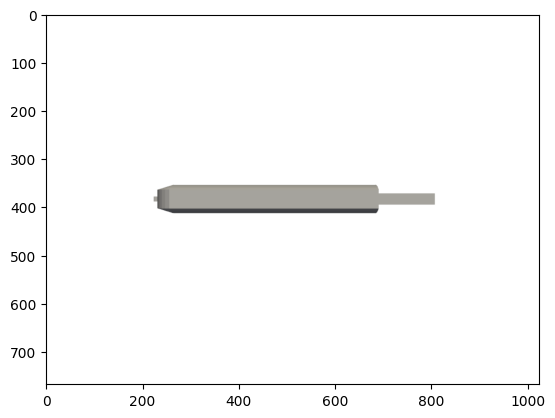

In [115]:
idx, mesh_ids, arrays = cmr.retrieve(text_proj, "text", "img", top_k=5)
img_path = f'Data/ShapeNetSem/Images/subset_200/{mesh_ids[idx[1]]}/view0.png'
img = plt.imread(img_path)
plt.imshow(img)

In [ ]:
idx, mesh_ids, arrays = cmr.retrieve(img_proj, "img", "text", top_k=5)
df.iloc[idx[2]]['template1_desc']

'A memorex flash drive which is commonly known as <no_tags>. It is associated with the following characteristics: memory device,storage device.\nA general description of this item is: a device that preserves information for retrieval.'

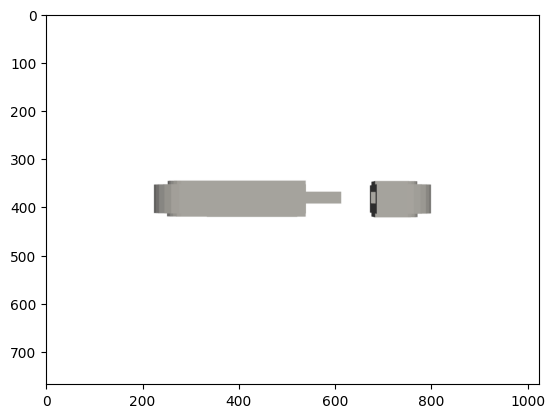

In [ ]:
idx, mesh_ids, arrays = cmr.retrieve(pc_proj, "pc", "img", top_k=5)
img_path = f'Data/ShapeNetSem/Images/subset_200/{mesh_ids[idx[1]]}/view1.png'
img = plt.imread(img_path)
plt.imshow(img)

In [116]:
idx, mesh_ids, arrays = cmr.retrieve(pc_proj, "img", "pc", top_k=5)
mesh_path = f'Data/ProcessedData/PointClouds/{mesh_ids[idx[1]]}.npy'
print(idx, mesh_ids)    

[3, 0, 4, 9, 1] 3    ab82d56cf9cc2476d154e1b098031d39
0      9a9508597dee231d4e205745311c3a
4    353fe70ec5633fc5e05878fff8971272
9    3d15f0b93dc94909ce92f6b720939174
1    71f6598d5426fb34c33dcf45f2780ed8
Name: fullId, dtype: object


In [ ]:
def get_aligned_output(dataset_path, img_dir, pc_dir, prompt, input_modality, output_modality, encoder, cmr):
    df = pd.read_csv(dataset_path)
    projection = encoder.get_projection(prompt, input_modality)
    idx, mesh_ids, arrays = cmr.retrieve(projection, input_modality, output_modality, top_k=5)

    if output_modality == "text":
        output = df.iloc[idx[2]]['template1_desc']
    elif output_modality == "img":
        output = f'{img_dir}{mesh_ids[idx[1]]}/view0.png'
    else:
        output = f'{pc_dir}{mesh_ids[idx[1]]}.obj'
    
    return output